# Execute aqui primeiro

In [16]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

## Morfologia II

### 1. Esqueletonização. Use a imagem 'horse'.

---

Para executar a transformação por esqueletização é preciso primeiro normalizar a imagem para grau de cinza, essa etapa é feita através do 
`cv.threshold`. Com isso, o objetivo é pegar os elementos da imagem com `cv.erode` (busca colocar na imagem os pixels que tem o kernel) e `cv.dilate` (Tem como principio "ampliar" ou "diminir" a imagem). Note que o kernel está em formato de cruz (`cv.MORPH_CROSS`). Assim, o resultado é igual ao `cv.bitwise_or(result, temp)`, sendo o `temp` o responsável por receber as operações. 

In [14]:
def esqueletizacao(path):
    
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Erro: Não foi possível carregar a imagem: {path}")
        return

    _, binaria = cv.threshold(img, 127, 255, cv.THRESH_BINARY)

    binaria = 255 - binaria

    
    kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))
    result = np.zeros(binaria.shape, np.uint8)

    temp = np.zeros(binaria.shape, np.uint8)
    img_ = binaria.copy()

    while True:
        erodido = cv.erode(img_, kernel)
        aberto = cv.dilate(erodido, kernel)
        temp = cv.subtract(img_, aberto)
        result = cv.bitwise_or(result, temp)
        img_ = erodido.copy()
        if cv.countNonZero(img_) == 0:
            break

    binaria = 255 - binaria
    result = 255 - result

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(binaria, cmap='gray')
    plt.title("Imagem Binária")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result, cmap='gray')
    plt.title("Esqueleto")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

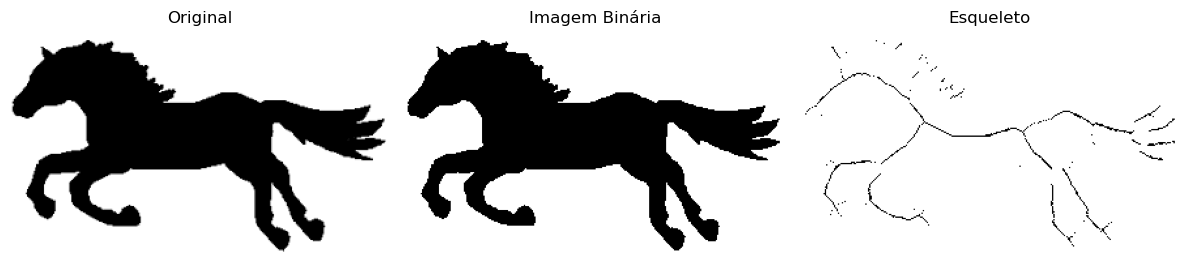

In [15]:
esqueletizacao('img/horse.png')

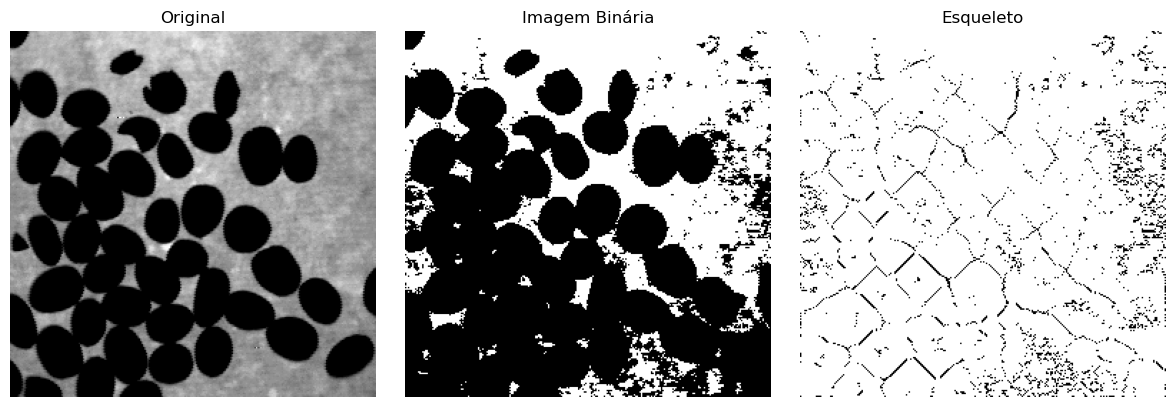

In [43]:
esqueletizacao('img/beans.png')

### 2. Reconstrução morfológica.
---

Tem como principio a transformação que visa restaurar ou reconstruir seletivamente componentes de uma imagem binária que estão conectados a um conjunto de pixels "marcadores" (Note que aqui tem que fazer a normalização também). Com isso, os limites definidos por uma segunda imagem "máscara". Em essência, ela "espalha" a influência dos marcadores até que atinja os limites da máscara.

In [37]:
# 2.1 dilatação Geodésica
def dilatacao_geodesica(marker, mask):
    kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))
    
    return np.logical_and(binary_dilation(marker, structure=kernel), mask)

In [38]:
# 2.2 reconstrução por dilatação
def reconstrucao_por_dilatacao(marker, mask):
    
    kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))
    
    prev = np.zeros_like(marker)
    current = marker.copy()
    
    while not np.array_equal(current, prev):
        prev = current
        current = dilatacao_geodesica(current, mask)
    return current

In [41]:
def reconstrucao_morfologica_completa(path):
    
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    if img is None:
        print("Erro ao carregar imagem.")
        return

    _, binaria = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
    bin_bool = binaria.astype(bool)

    #estrutura que ira fazer as o
    kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))

    # 2.4 abertura por reconstrução
    erodida = cv.erode(binaria, kernel, iterations=1)
    erodida_bool = erodida.astype(bool)
    abertura_recon = reconstrucao_por_dilatacao(erodida_bool, bin_bool)

    # 2.5 eliminação de elementos de Borda
    inv = np.logical_not(bin_bool)
    marcador_borda = np.zeros_like(inv, dtype=bool)
    marcador_borda[0, :] = inv[0, :]
    marcador_borda[-1, :] = inv[-1, :]
    marcador_borda[:, 0] = inv[:, 0]
    marcador_borda[:, -1] = inv[:, -1]

    reconstr_borda = reconstrucao_por_dilatacao(marcador_borda, inv)
    sem_borda = np.logical_and(inv, np.logical_not(reconstr_borda))

    
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 3, 1)
    plt.imshow(binaria, cmap='gray')
    plt.title('Imagem Binária')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(abertura_recon, cmap='gray')
    plt.title('Abertura por Reconstrução')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(sem_borda, cmap='gray')
    plt.title('Sem Objetos de Borda')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(reconstrucao_por_dilatacao(erodida_bool, bin_bool), cmap='gray')
    plt.title('Reconstr. por Dilatação')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(dilatacao_geodesica(erodida_bool, bin_bool), cmap='gray')
    plt.title('Dilatação Geodésica (1 iteração)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

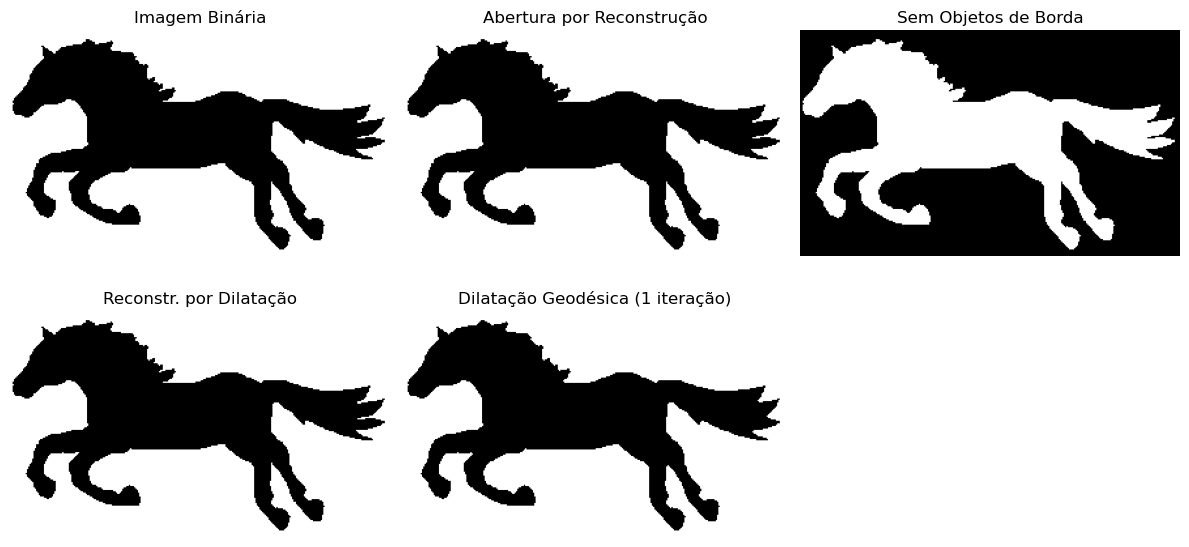

In [42]:
reconstrucao_morfologica_completa('img/horse.png')